In [1]:
from utils import Logger

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [2]:
def mnist_data():
    compose = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [3]:
data = mnist_data()

data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

num_batches = len(data_loader)

In [4]:
class DiscriminatorNet(torch.nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [5]:
class GeneratorNet(torch.nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

def noise(size):
    n = Variable(torch.randn(size, 100))
    return n

In [6]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

In [7]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

loss = nn.BCELoss()

In [8]:
# real-images targets (always ones)
def real_images_target(size):
    data = Variable(torch.ones(size, 1))
    return data

# fake-images targets (always zeros)
def fake_images_target(size):
    data = Variable(torch.zeros(size, 1))
    return data

In [9]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    
    optimizer.zero_grad()
    
    # train on real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, real_images_target(N))
    error_real.backward()
    
    # train on fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, fake_images_target(N))
    error_fake.backward()
    
    # update weights with gradients
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    N = fake_data.size(0)

    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_images_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [10]:
# for testing purposes, create static batch of noise, then visualize batch of outputs every few steps
num_test_samples = 16
test_noise = noise(num_test_samples)

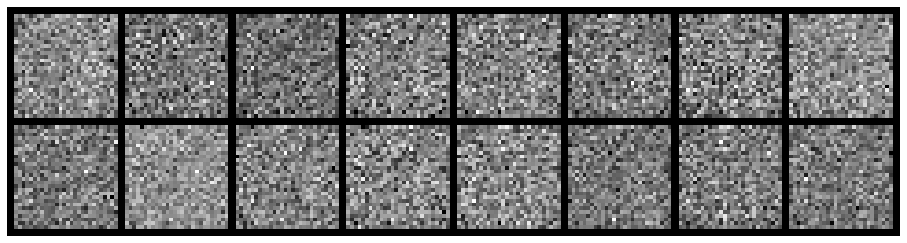

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.3913, Generator Loss: 0.6855
D(x): 0.5014, D(G(z)): 0.5037


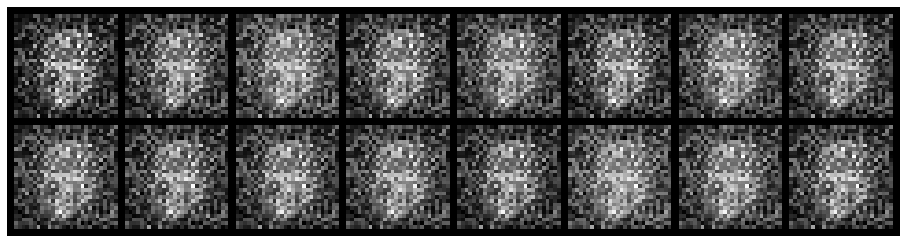

Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 2.8332, Generator Loss: 0.0924
D(x): 0.7932, D(G(z)): 0.9112


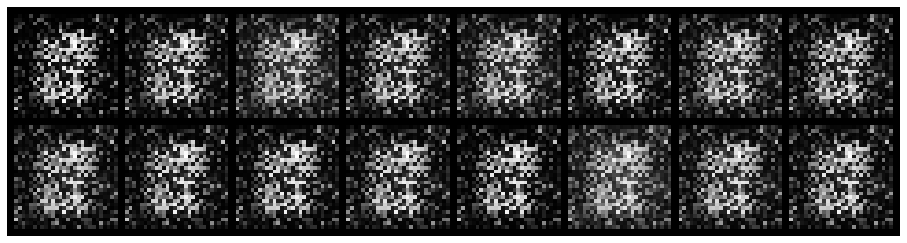

Epoch: [0/200], Batch Num: [200/600]
Discriminator Loss: 1.0380, Generator Loss: 1.6246
D(x): 0.6479, D(G(z)): 0.4093


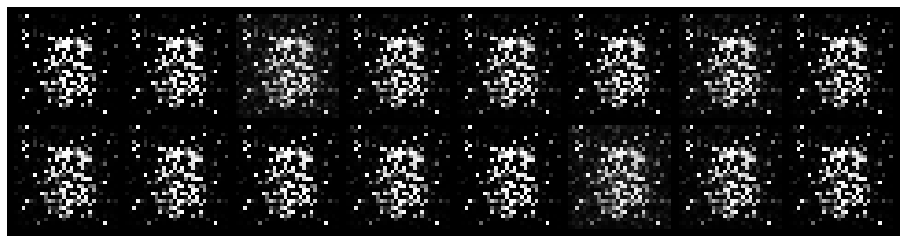

Epoch: [0/200], Batch Num: [300/600]
Discriminator Loss: 0.4629, Generator Loss: 4.3339
D(x): 0.8237, D(G(z)): 0.1360


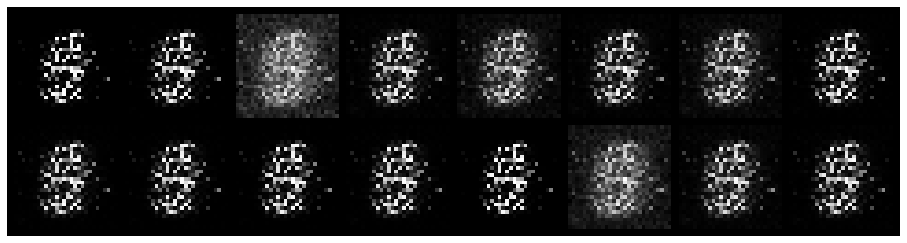

Epoch: [0/200], Batch Num: [400/600]
Discriminator Loss: 0.5191, Generator Loss: 3.9043
D(x): 0.8075, D(G(z)): 0.1943


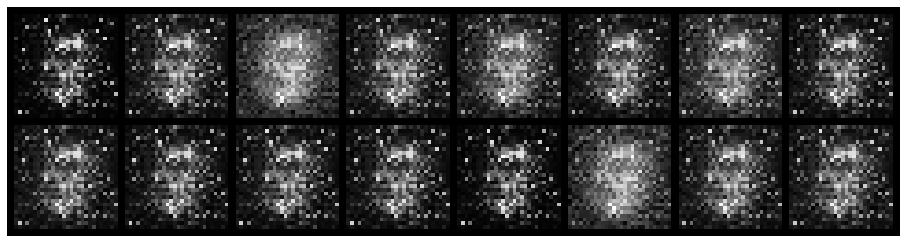

Epoch: [0/200], Batch Num: [500/600]
Discriminator Loss: 1.5111, Generator Loss: 1.1605
D(x): 0.6175, D(G(z)): 0.5370


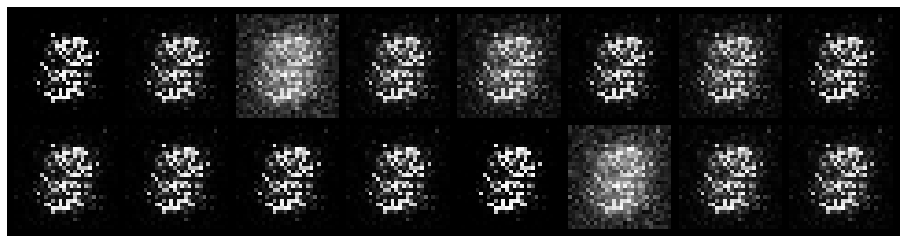

Epoch: [1/200], Batch Num: [0/600]
Discriminator Loss: 0.6717, Generator Loss: 2.1737
D(x): 0.7650, D(G(z)): 0.2422


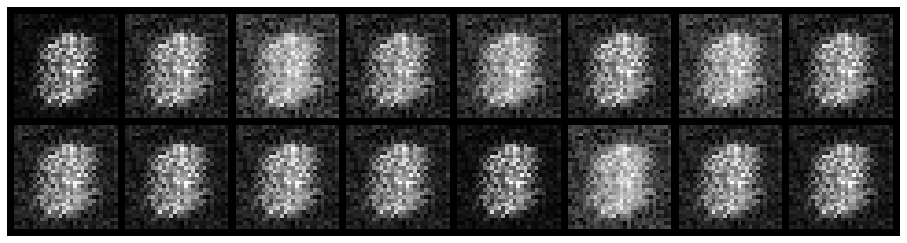

Epoch: [1/200], Batch Num: [100/600]
Discriminator Loss: 0.8149, Generator Loss: 2.1639
D(x): 0.7264, D(G(z)): 0.3299


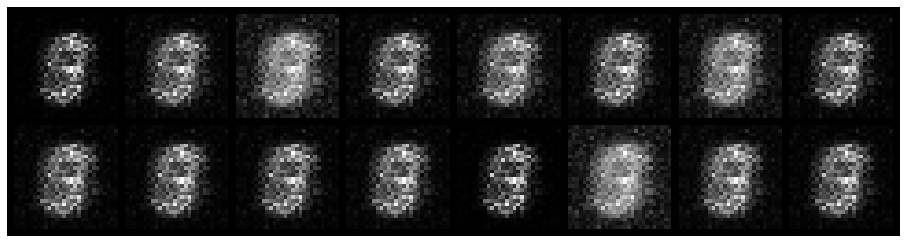

Epoch: [1/200], Batch Num: [200/600]
Discriminator Loss: 1.7549, Generator Loss: 0.7998
D(x): 0.4847, D(G(z)): 0.5346


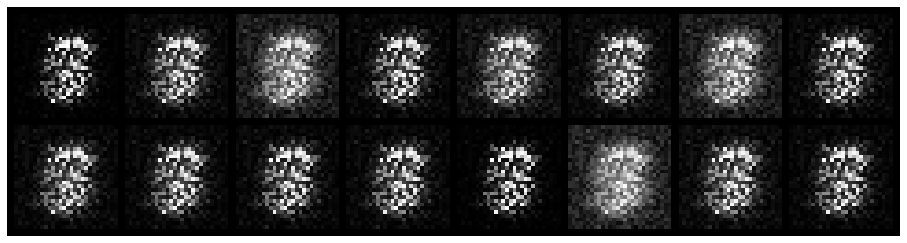

Epoch: [1/200], Batch Num: [300/600]
Discriminator Loss: 0.3983, Generator Loss: 2.6194
D(x): 0.8532, D(G(z)): 0.1818


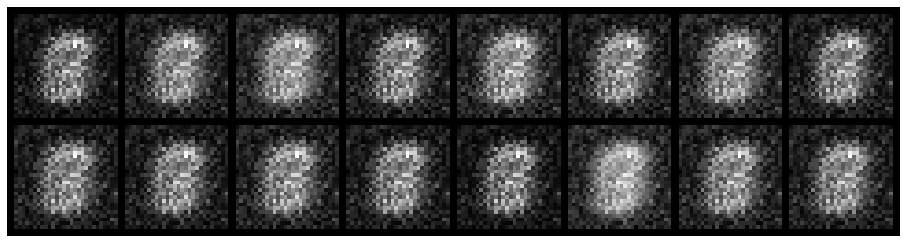

Epoch: [1/200], Batch Num: [400/600]
Discriminator Loss: 1.6885, Generator Loss: 0.5911
D(x): 0.7474, D(G(z)): 0.7127


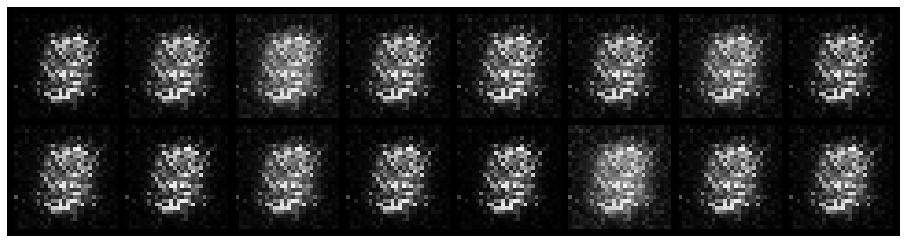

Epoch: [1/200], Batch Num: [500/600]
Discriminator Loss: 0.7337, Generator Loss: 4.0581
D(x): 0.6938, D(G(z)): 0.1987


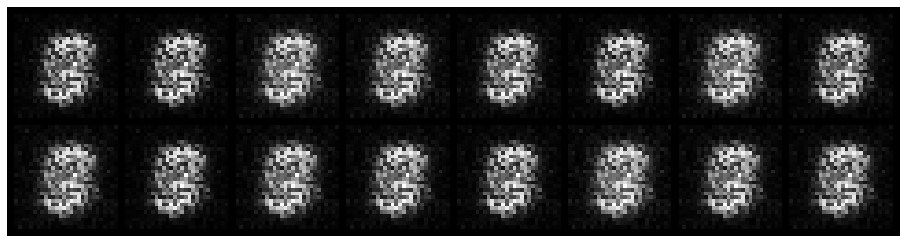

Epoch: [2/200], Batch Num: [0/600]
Discriminator Loss: 0.8636, Generator Loss: 2.3309
D(x): 0.6415, D(G(z)): 0.2743


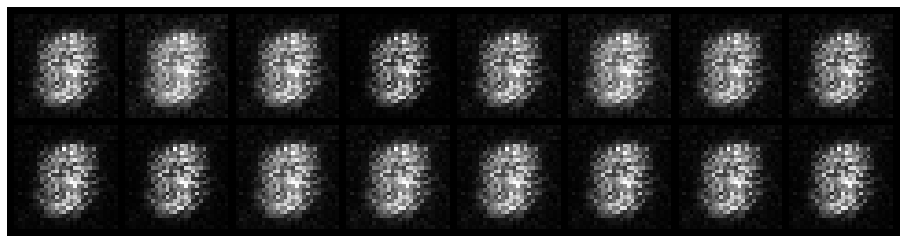

Epoch: [2/200], Batch Num: [100/600]
Discriminator Loss: 1.3741, Generator Loss: 1.5930
D(x): 0.5643, D(G(z)): 0.3554


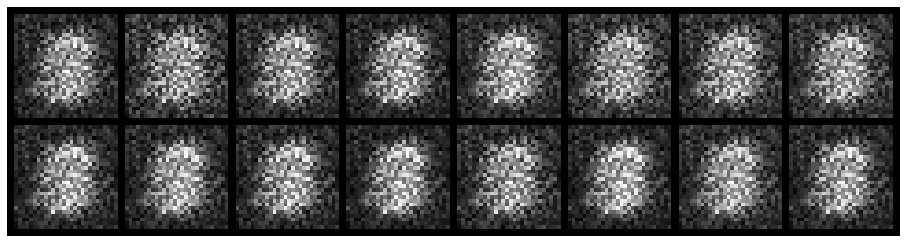

Epoch: [2/200], Batch Num: [200/600]
Discriminator Loss: 1.0969, Generator Loss: 1.2029
D(x): 0.7277, D(G(z)): 0.4809


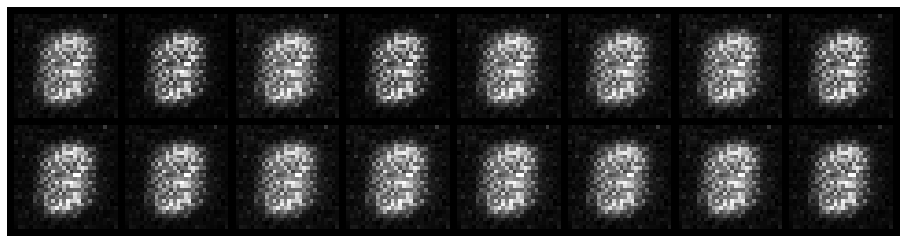

Epoch: [2/200], Batch Num: [300/600]
Discriminator Loss: 1.8483, Generator Loss: 1.1432
D(x): 0.4942, D(G(z)): 0.5544


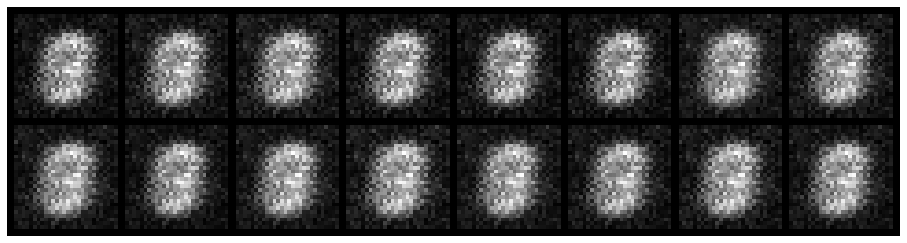

Epoch: [2/200], Batch Num: [400/600]
Discriminator Loss: 1.1017, Generator Loss: 1.2203
D(x): 0.6373, D(G(z)): 0.4027


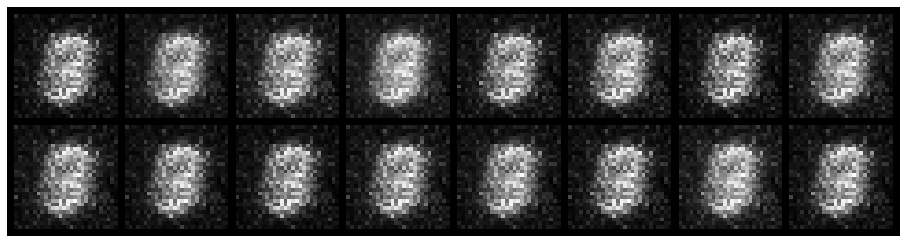

Epoch: [2/200], Batch Num: [500/600]
Discriminator Loss: 1.5966, Generator Loss: 1.1172
D(x): 0.6196, D(G(z)): 0.5240


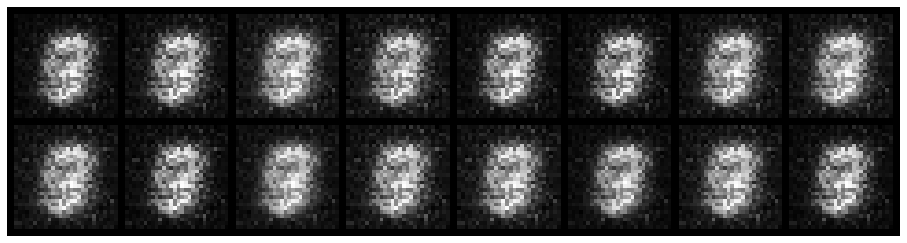

Epoch: [3/200], Batch Num: [0/600]
Discriminator Loss: 1.4551, Generator Loss: 1.2040
D(x): 0.6327, D(G(z)): 0.4884


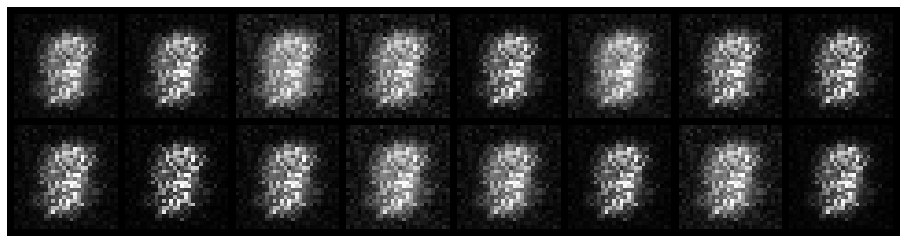

Epoch: [3/200], Batch Num: [100/600]
Discriminator Loss: 1.0283, Generator Loss: 2.0165
D(x): 0.7248, D(G(z)): 0.3702


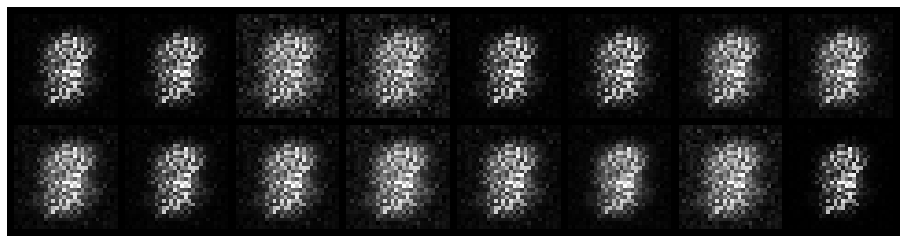

Epoch: [3/200], Batch Num: [200/600]
Discriminator Loss: 0.5831, Generator Loss: 2.9497
D(x): 0.7807, D(G(z)): 0.2236


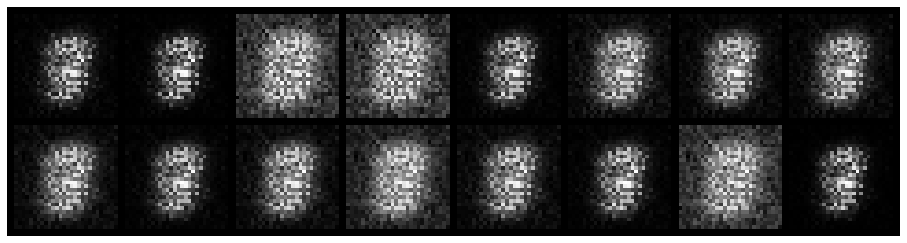

Epoch: [3/200], Batch Num: [300/600]
Discriminator Loss: 1.1230, Generator Loss: 1.1130
D(x): 0.6626, D(G(z)): 0.4060


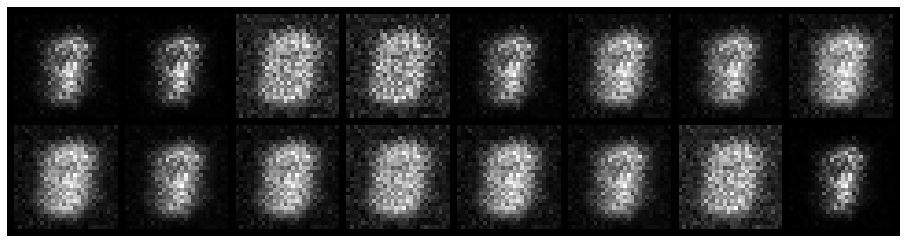

Epoch: [3/200], Batch Num: [400/600]
Discriminator Loss: 0.7474, Generator Loss: 2.3459
D(x): 0.7660, D(G(z)): 0.2740


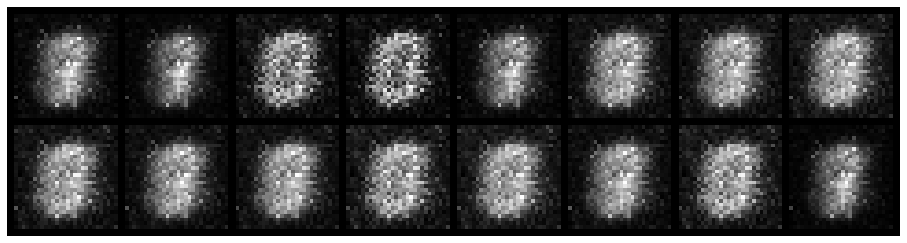

Epoch: [3/200], Batch Num: [500/600]
Discriminator Loss: 0.7780, Generator Loss: 1.4284
D(x): 0.7819, D(G(z)): 0.3071


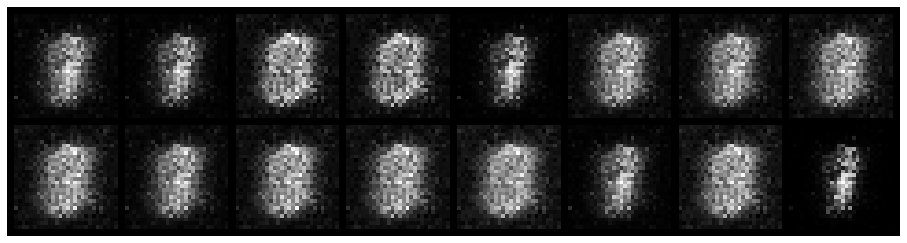

Epoch: [4/200], Batch Num: [0/600]
Discriminator Loss: 0.7597, Generator Loss: 2.5289
D(x): 0.8024, D(G(z)): 0.2271


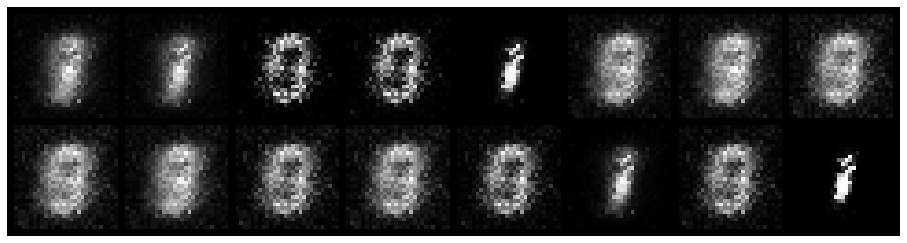

Epoch: [4/200], Batch Num: [100/600]
Discriminator Loss: 0.7771, Generator Loss: 2.0357
D(x): 0.7314, D(G(z)): 0.1647


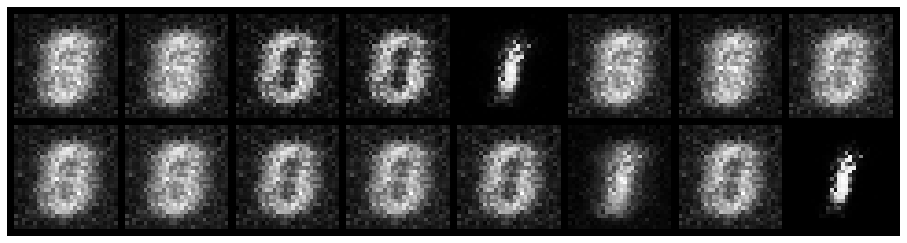

Epoch: [4/200], Batch Num: [200/600]
Discriminator Loss: 0.7696, Generator Loss: 2.4063
D(x): 0.7397, D(G(z)): 0.1719


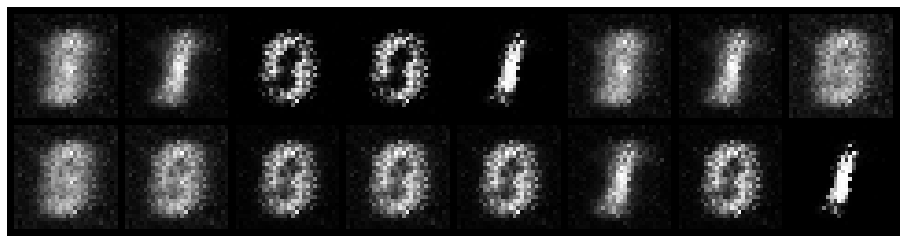

Epoch: [4/200], Batch Num: [300/600]
Discriminator Loss: 0.5199, Generator Loss: 2.5384
D(x): 0.8658, D(G(z)): 0.1880


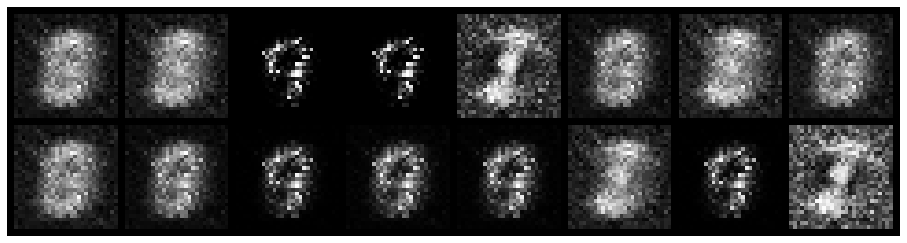

Epoch: [4/200], Batch Num: [400/600]
Discriminator Loss: 0.9708, Generator Loss: 1.8563
D(x): 0.7171, D(G(z)): 0.3033


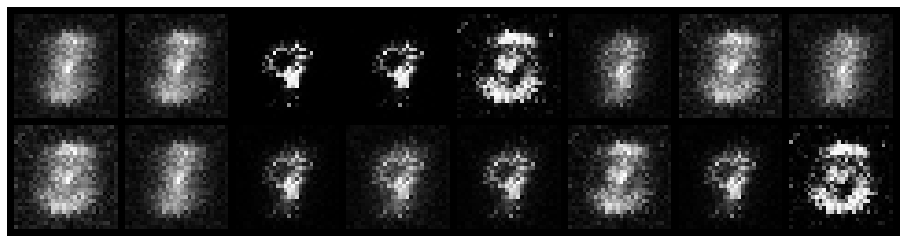

Epoch: [4/200], Batch Num: [500/600]
Discriminator Loss: 0.4771, Generator Loss: 2.6391
D(x): 0.8598, D(G(z)): 0.1652


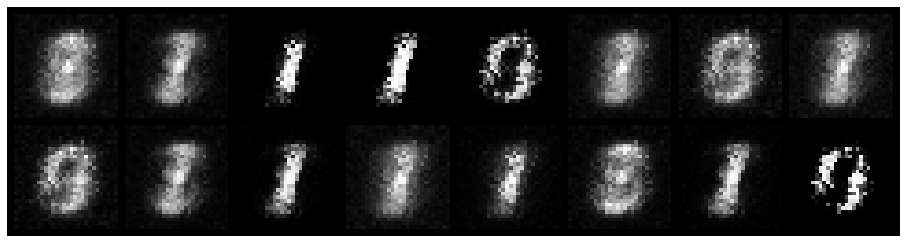

Epoch: [5/200], Batch Num: [0/600]
Discriminator Loss: 0.9376, Generator Loss: 2.3547
D(x): 0.7881, D(G(z)): 0.2864


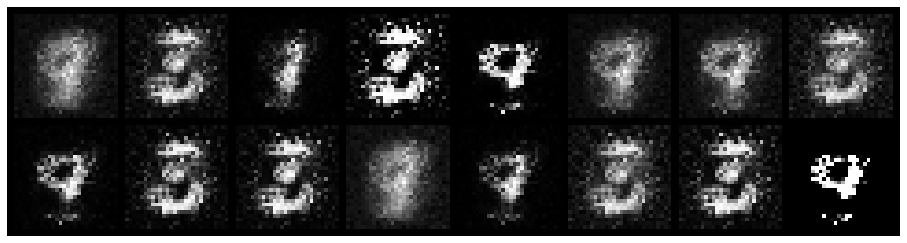

Epoch: [5/200], Batch Num: [100/600]
Discriminator Loss: 0.5511, Generator Loss: 2.4702
D(x): 0.8508, D(G(z)): 0.1659


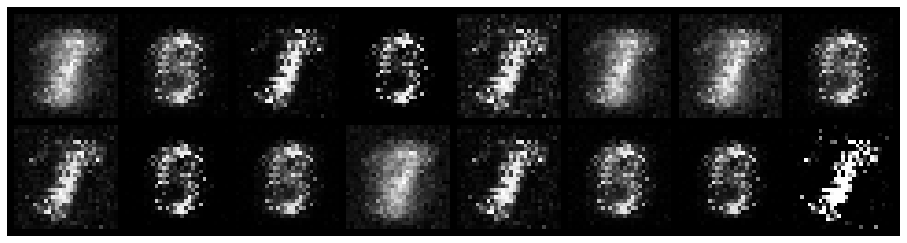

Epoch: [5/200], Batch Num: [200/600]
Discriminator Loss: 0.4032, Generator Loss: 2.8635
D(x): 0.8910, D(G(z)): 0.1484


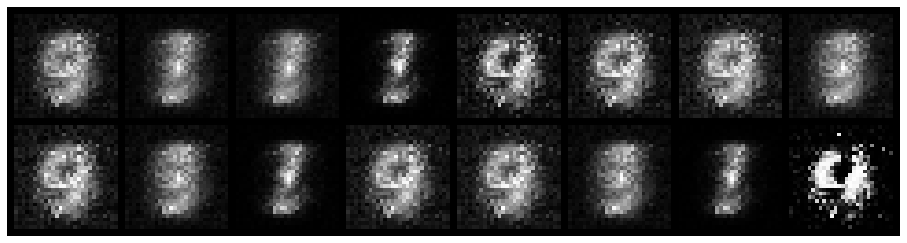

Epoch: [5/200], Batch Num: [300/600]
Discriminator Loss: 0.6401, Generator Loss: 2.4964
D(x): 0.9093, D(G(z)): 0.3304


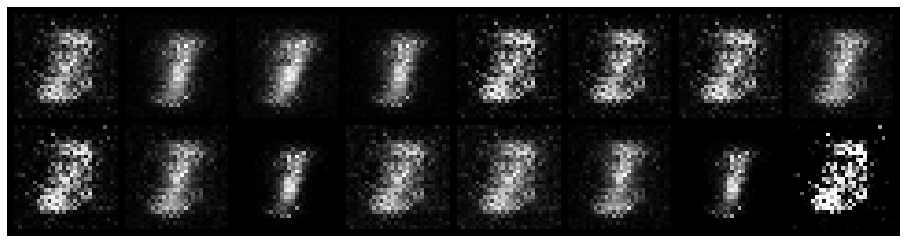

Epoch: [5/200], Batch Num: [400/600]
Discriminator Loss: 0.2465, Generator Loss: 3.8938
D(x): 0.9037, D(G(z)): 0.0667


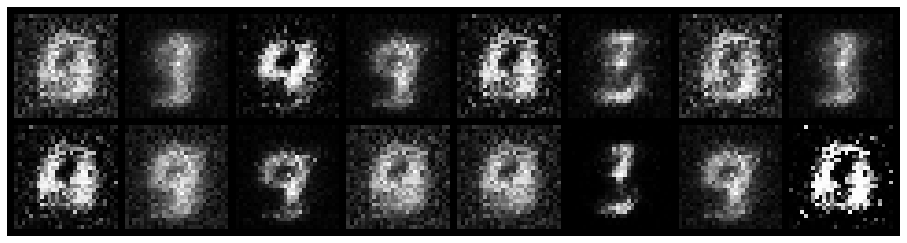

Epoch: [5/200], Batch Num: [500/600]
Discriminator Loss: 0.4791, Generator Loss: 2.6282
D(x): 0.8754, D(G(z)): 0.1720


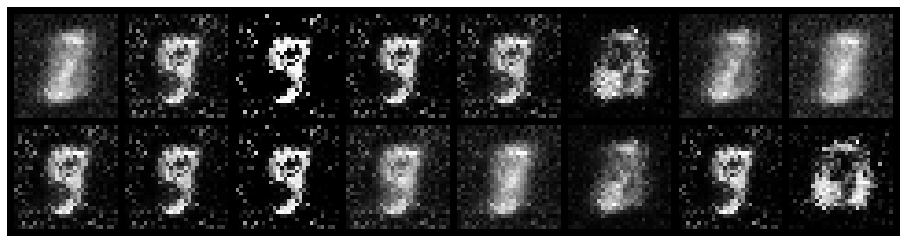

Epoch: [6/200], Batch Num: [0/600]
Discriminator Loss: 0.6318, Generator Loss: 2.7603
D(x): 0.8436, D(G(z)): 0.2058


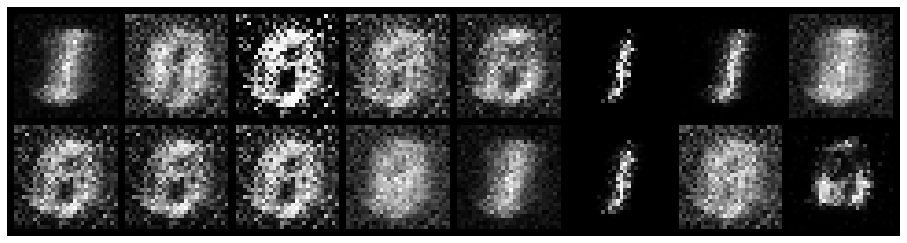

Epoch: [6/200], Batch Num: [100/600]
Discriminator Loss: 0.4835, Generator Loss: 2.7235
D(x): 0.8998, D(G(z)): 0.2101


In [ ]:
logger = Logger(model_name='VGAN', data_name='MNIST')

num_epochs = 200

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        
        # train discriminator
        real_data = Variable(images_to_vectors(real_batch))
        fake_data = generator(noise(N)).detach()
        
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)
        
        # train generator
        fake_data = generator(noise(N))
        
        g_error = train_generator(g_optimizer, fake_data)
        
        # log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # display progress for human tester
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )